<a href="https://colab.research.google.com/github/rvoloder/sales-predictions/blob/main/Copy_of_Final_Project_Sales_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(display = 'diagram')

# Load data:

In [5]:
filename = "/content/drive/MyDrive/Coding Dojo/01 Stack Week 2: Pandas/sales_predictions.csv"

df = pd.read_csv(filename)
df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


# Data Cleaning

Are there any duplicates?

In [7]:
df.duplicated().sum()

## No!

0

Identify missing values:

From above (df.info()), Item_Weight and Outlet_Size have missing values.

As I am not using any numerical calculations or frequency assessments, I am choosing to deduce and impute some of the missing data by making links in the available data. This will not cause any data leakage. 

For Outlet_Size, I will first check how the Outlet_Size is categorized and how much of each category is present:

In [8]:
df['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

The above count does not show that a mode (most common value) would be of use here.

If we look back on our data, we see that although we do not have all the Outlet_Sizes, we do have every Outlet_Type of each item.

If we look at the value counts of our Outlet_Types, we notice an interesting pattern.


In [9]:
df.groupby('Outlet_Size')['Outlet_Type'].value_counts()

Outlet_Size  Outlet_Type      
High         Supermarket Type1     932
Medium       Supermarket Type3     935
             Supermarket Type1     930
             Supermarket Type2     928
Small        Supermarket Type1    1860
             Grocery Store         528
Name: Outlet_Type, dtype: int64

In [10]:
df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

From the info above, we can first see that if a type is a 'Grocery Store', the size category is always small.

It would be logical to infer that any 'Grocery Store' type would be a small size store.

This also makes sense with the name, as a 'Supermarket' is usually a large 'Grocery Store'.

Using this inference, we will replace the missing values for Outlet_Size with 'Small', if the Outlet_Type is 'Grocery Store'.


In [11]:
grocery_store_filter = df['Outlet_Type'] == 'Grocery Store'

df.loc[grocery_store_filter, 'Outlet_Size'] = 'Small'
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6668 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Using this same logic we see that all Supermarket Type2 and Supermarket Type3 appear to be medium sized.

Unfortunately, when we look further, all Supermarket Type2 and Type3 have been categorized as medium.


In [12]:
df.groupby('Outlet_Size')['Outlet_Type'].value_counts()


Outlet_Size  Outlet_Type      
High         Supermarket Type1     932
Medium       Supermarket Type3     935
             Supermarket Type1     930
             Supermarket Type2     928
Small        Supermarket Type1    1860
             Grocery Store        1083
Name: Outlet_Type, dtype: int64

In [13]:
df['Outlet_Size'].value_counts()

Small     2943
Medium    2793
High       932
Name: Outlet_Size, dtype: int64

If we look deeper into the location types, we notice that Tier 2 locations always appear to be 'Small' size.


In [14]:
df.groupby('Outlet_Location_Type')['Outlet_Size'].value_counts()

Outlet_Location_Type  Outlet_Size
Tier 1                Small          1458
                      Medium          930
Tier 2                Small           930
Tier 3                Medium         1863
                      High            932
                      Small           555
Name: Outlet_Size, dtype: int64

If we attempt to change the Tier 2 locations to small, we see that we have filled in our missing data!


In [15]:
tier2_filter = df['Outlet_Location_Type'] == 'Tier 2'

df.loc[tier2_filter, 'Outlet_Size'] = 'Small'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


# Data Visualization:

Let's explore our data visually before we jump into modeling:

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

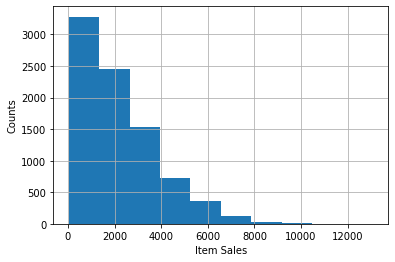

In [17]:
df['Item_Outlet_Sales'].hist();
plt.xlabel('Item Sales');
plt.ylabel('Counts');

The above graph shows that a majority of Items fall in the range of 0 to 4000 in sales. This shows that we really only have a few items that we would consider bestsellers. It would be interesting to evaluate which products make more than 4000 or even 6000 and try and figure out a correlation to other factors. Maybe we can discover a way to better sales for the less popular items.

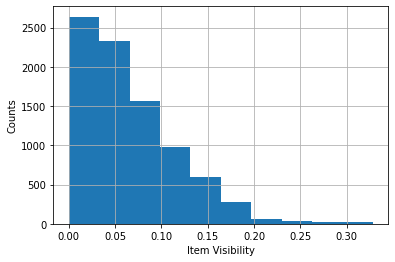

In [18]:
df['Item_Visibility'].hist();
plt.xlabel('Item Visibility');
plt.ylabel('Counts');

The histogram above shows that a majority of the products have low item visibility (i.e. that they have lower amounts of shelf space to display the products percentage-wise). Something like this could be a good indicator of higher or lower sales predictions. The logical assumption would be that the more "visible" the product is, the better it sells. But we seem to have very little items that are highly visible, which could be affecting sales.

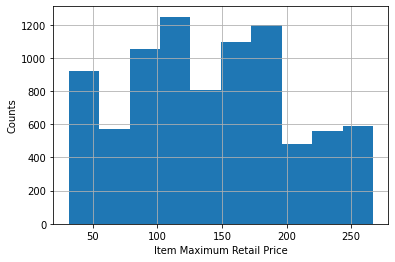

In [19]:
df['Item_MRP'].hist();
plt.xlabel('Item Maximum Retail Price');
plt.ylabel('Counts');

The chart above shows that the maximum price at which stores can sell each product vary greatly although most seem to fall in the middle range between 75 and 190. It would be interesting to take a look and compare how items with higher and lower retail prices sell comparatively. Are the bestsellers located in the higher or lower MRP range?

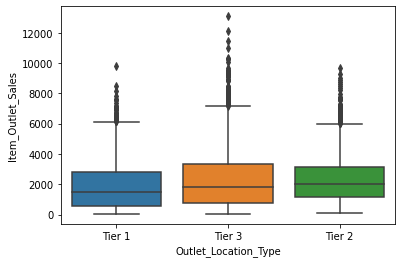

In [20]:
sns.boxplot(data = df, x = 'Outlet_Location_Type', y = 'Item_Outlet_Sales');

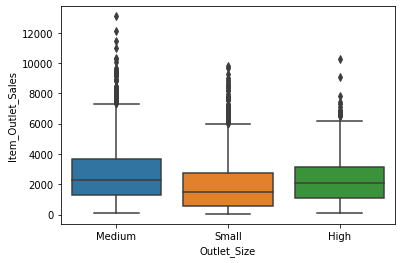

In [21]:
sns.boxplot(data = df, x = 'Outlet_Size', y = 'Item_Outlet_Sales');

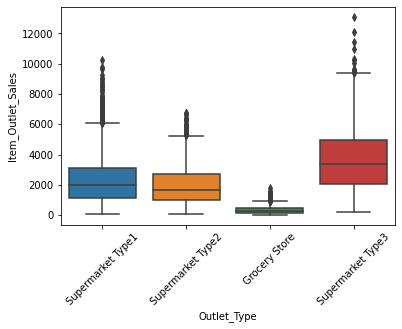

In [22]:
sns.boxplot(data = df, x = 'Outlet_Type', y = 'Item_Outlet_Sales');
plt.xticks(rotation = 45);

The three boxplots above further confirm that our outliers (i.e. our bestsellers) usually fall in the range above 6000 in item sales. It also shows that "Medium" sized outlets tend to have higher sales per item then "Small" or "Big" outlets. We can also see that Tier 1 stores tend to be the worst performing, their 25 to 75 percentile range falling a bit lower than those of Tier 2 and Tier 3 stores. Tier 3 stores appear to have the most amount of outliers (high selling items) and it would be a good idea to investigate why that is. The final boxplot also shows us that "Supermarket Type 3" stores seem to be by far the best sellers among the stores whereas the "Grocery Store" seems to be by far the worst performing. It might even be a good idea to take a look and see if the Grocery Stores are even worth having. And to see why it is that the Type 3 stores seem to be the most successful (i.e. is it because of item type, visibility, something else?).

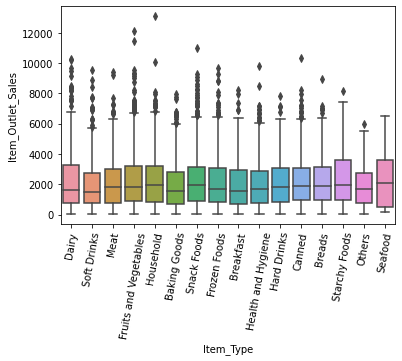

In [23]:
sns.boxplot(data = df, x = 'Item_Type', y = 'Item_Outlet_Sales');
plt.xticks(rotation = 80);

The boxplot above shows us a good distribution of item sales per type. From this we can see a few interesting points. Some of our better sellers on average seem to be in the seafood, dairy, and starchy foods categories. This would be an interesting thing to explore and see if these items tend to have better item visibility or are located in certain types of stores that allow them to sell better. We can also see clearly where our biggest outliers are located. We should take a look at which items in certain categories (esp. fruits and vegetables, household, and snack foods) account fo rmost of our sales and what it is about these items that make them such good sellers. These factors we can then implement on items that seem to be selling not as well. 

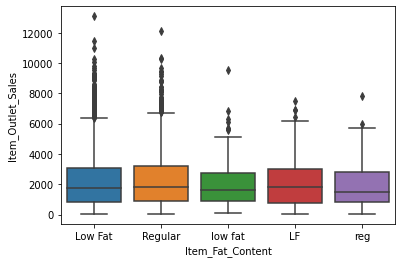

In [24]:
sns.boxplot(data = df, x = 'Item_Fat_Content', y = 'Item_Outlet_Sales');

In comparing the fat content of items on sales, we see that the distribution is fairly even. It does appear that a few more outliers (higher selling items) appear to be "Low Fat" items, which would be interesting to take a look at. But it does not appear that one cateogry is far superior to the other in sales.

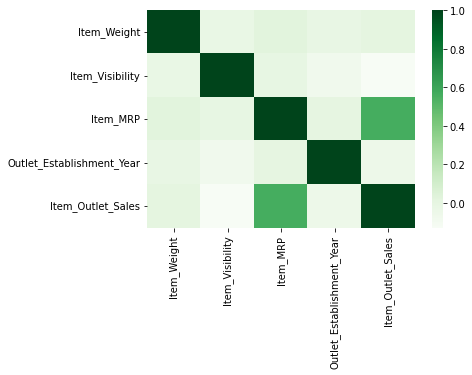

In [25]:
corr = df.corr()
sns.heatmap(corr, cmap = 'Greens');

To investigate some of our assumptions further, we can create a heatmap to show correlations between various categories in our data. Although it appears that most of the data is only slightly correlated, we see that Item MRP (or Maximum Retail Price is strongly correlated with our Item Outlet Sales. This seems like it will be a key indicator for our sales predictions to come. 

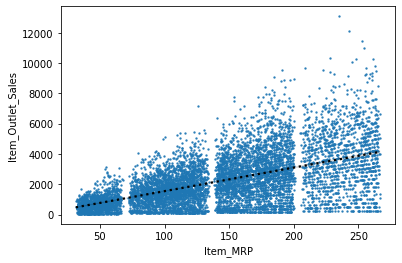

In [26]:
sns.regplot(data = df, x = 'Item_MRP', y = 'Item_Outlet_Sales',
            scatter_kws = {'s':2},
            line_kws = dict(color = 'black', ls = ':'));

There appears to be a positive correlation between the Item's Maximum Retail Price and the item's Outlet Sales.

# Let's prepare our data for modeling:

We will now do some ordinal encoding to convert our data to numbers and make it useable for machine learning:


In [27]:
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [28]:
replacement_dictionary = {'Low Fat': 0, 'LF': 0, 'low fat': 0, 'Regular': 1, 'reg': 1}
df['Item_Fat_Content'].replace(replacement_dictionary, inplace = True)

In [29]:
df['Outlet_Size'].value_counts()

Small     4798
Medium    2793
High       932
Name: Outlet_Size, dtype: int64

In [30]:
replacement_dictionary_2 = {'Small': 0, 'Medium': 1, 'High': 2}
df['Outlet_Size'].replace(replacement_dictionary_2, inplace = True)

In [31]:
df['Outlet_Location_Type'].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

Tier 1 are top tier locations found in big cities. Tier 2 are smaller cities, Tier 3 very small cities and towns (based on my research on the real estate location types).


In [32]:
replacement_dictionary_3 = {'Tier 3': 0, 'Tier 2': 1, 'Tier 1': 2}
df['Outlet_Location_Type'].replace(replacement_dictionary_3, inplace = True)

Let's split our data into a training and target data:


In [33]:
X = df.drop('Item_Outlet_Sales', axis = 1)
y = df['Item_Outlet_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

Instantiate column selectors:

In [34]:
cat_selector = make_column_selector(dtype_include = 'object')
num_selector = make_column_selector(dtype_include = 'number')

Instantiate Transformers:

In [35]:
freq_imputer = SimpleImputer(strategy = 'most_frequent')
mean_imputer = SimpleImputer(strategy = 'mean')

scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse = False)

Instantiate pipelines:


In [36]:
numeric_pipe = make_pipeline(mean_imputer, scaler)
categorical_pipe = make_pipeline(freq_imputer, ohe)

Instantiate ColumnTransformer:

In [37]:
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)

preprocessor = make_column_transformer(number_tuple, category_tuple)

Transform data:

In [38]:
preprocessor.fit(X_train)

X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [39]:
X_train_processed

array([[ 0.81724868, -0.7403206 , -0.71277507, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.5563395 ,  1.35076614, -1.29105225, ...,  0.        ,
         1.        ,  0.        ],
       [-0.13151196,  1.35076614,  1.81331864, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.11373638, -0.7403206 , -0.92052713, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.76600931, -0.7403206 , -0.2277552 , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.81724868, -0.7403206 , -0.95867683, ...,  1.        ,
         0.        ,  0.        ]])

# Linear Regression Model:

1. Build a linear regression model to predict sales:

In [40]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train_processed, y_train)

LinearRegression()

Evaluate your model based on r2:

In [41]:
train_score = reg.score(X_train_processed, y_train)
test_score = reg.score(X_test_processed, y_test)
print(train_score)
print(test_score)

0.6716512323850465
-2.107153212118096e+18


From the above r2, it does not seem that our model is performing at all well on the testing data. The r2 appears to be a negative value, which would imply that the model is performing worse than had we just fit a horizontal line on a graph of the data and used that for predictions. 

Evaluate your model based on rmse:


In [42]:
from sklearn.metrics import mean_squared_error

train_preds = reg.predict(X_train_processed)
test_preds = reg.predict(X_test_processed)

rmse_train = np.sqrt(mean_squared_error(y_train, train_preds))
rmse_test = np.sqrt(mean_squared_error(y_test, test_preds))

print(rmse_train)
print(rmse_test)

985.7655062905881
2411138290136.562


The rmse also seem to be wildly different when calculated and would imply a very poor model.

# Regression Tree Model:

2. Build a Regression Tree Model to predict sales:

In [43]:
from sklearn.tree import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor(random_state = 42)
dec_tree.fit(X_train_processed, y_train)

DecisionTreeRegressor(random_state=42)

In [44]:
dec_tree.get_depth()

60

In [45]:
train_score = dec_tree.score(X_train_processed, y_train)
test_score = dec_tree.score(X_test_processed, y_test)
print(train_score)
print(test_score)

1.0
0.20750590480382314


The model is overfit for the training data with a very high variance. 
It is performing very poorly on the testing data.

Let's find an adequate maximum depth to tune our model and reduce variance and bias:


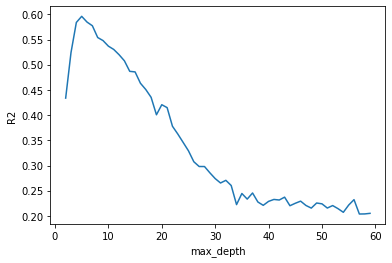

In [46]:
import matplotlib.pyplot as plt

max_depth_range = list(range(2,60))
r2 = []
for depth in max_depth_range:
  dec_tree = DecisionTreeRegressor(max_depth = depth, random_state = 42)
  dec_tree.fit(X_train_processed, y_train)
  score = dec_tree.score(X_test_processed, y_test)
  r2.append(score)

plt.plot(max_depth_range, r2)
plt.xlabel('max_depth')
plt.ylabel('R2');

It appears that the best max_depth (with the highest r2) is around 5 or 6:

In [47]:
dec_tree_5 = DecisionTreeRegressor(max_depth = 5,  random_state = 42)
dec_tree_5.fit(X_train_processed, y_train)

train_score_5 = dec_tree_5.score(X_train_processed, y_train)
test_score_5 = dec_tree_5.score(X_test_processed, y_test)
print(train_score_5)
print(test_score_5)

0.6042066848171654
0.5960564372160062


In [48]:
dec_tree_6 = DecisionTreeRegressor(max_depth = 6,  random_state = 42)
dec_tree_6.fit(X_train_processed, y_train)

train_score_6 = dec_tree_6.score(X_train_processed, y_train)
test_score_6 = dec_tree_6.score(X_test_processed, y_test)
print(train_score_6)
print(test_score_6)

0.6157022844525739
0.5846684022696164


From the above code we can see that the max_depth of 5 is performing the best.

Compare the performance of the model based on r^2:


In [49]:
train_score_5 = dec_tree_5.score(X_train_processed, y_train)
test_score_5 = dec_tree_5.score(X_test_processed, y_test)
print(train_score_5)
print(test_score_5)

0.6042066848171654
0.5960564372160062


This regression tree model seems to be performing much better than our linear regression model. There is a very low variance between the training and testing data and a fairly low bias. The model appears to be able to make fairly adequate sales predicitions for the stores.

Compare the performance of the model based on rmse:


In [50]:
train_preds_tree = dec_tree_5.predict(X_train_processed)
test_preds_tree = dec_tree_5.predict(X_test_processed)

rmse_train = np.sqrt(mean_squared_error(y_train, train_preds_tree))
rmse_test = np.sqrt(mean_squared_error(y_test, test_preds_tree))

print(rmse_train)
print(rmse_test)

1082.281287111312
1055.6851402178304


Similar to the r2 evaluation, the rmse is also showing much better performance, the two numbers from the testing and training data being very similar. The model seems to be good enough to be put into use. 

Based on the evaluation and examples given for the r2 and rmse above, I would recommend using the regression tree model. It seems to be performing much better than the linear regression model and can predict with fairly good accuarcy future sales predicitions. Both r2 and rmse factors on the regression tree are an extreme improvement on the very poor numbers that the linear regression model seems to be giving us. 